In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
path = 'C:\\Users\\User\\Downloads\\archive\\dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [3]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path     Labels
0  C:\Users\User\Downloads\archive\dataset\glaze\...      glaze
1  C:\Users\User\Downloads\archive\dataset\lightn...  lightning
2  C:\Users\User\Downloads\archive\dataset\rain\1...       rain
3  C:\Users\User\Downloads\archive\dataset\sandst...  sandstorm
4  C:\Users\User\Downloads\archive\dataset\dew\23...        dew

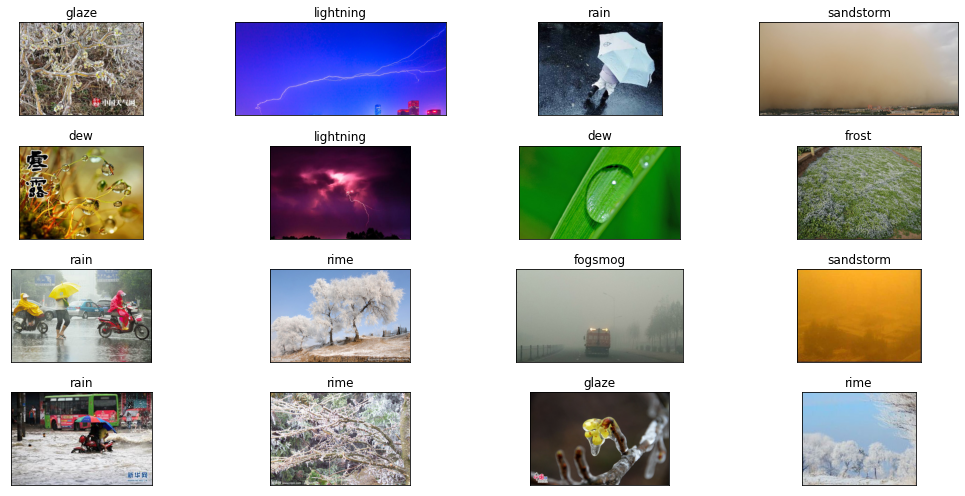

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

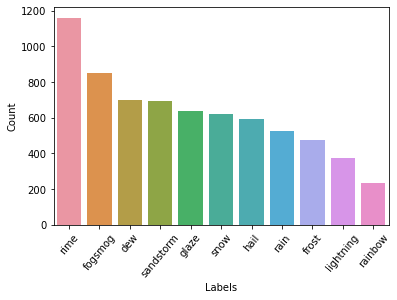

In [5]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# EfficientNetB7

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 169s 4s/step
              precision    recall  f1-score   support

         dew       0.85      0.85      0.85       145
     fogsmog       0.68      0.94      0.79       176
       frost       0.66      0.45      0.53        87
       glaze       0.65      0.68      0.66       116
        hail       0.74      0.96      0.84       113
   lightning       0.75      0.93      0.83        74
        rain       0.86      0.77      0.81       115
     rainbow       0.94      0.89      0.91        53
        rime       0.84      0.79      0.82       230
   sandstorm       0.94      0.55      0.70       143
        snow       0.62      0.57      0.59       121

    accuracy                           0.76      1373
   macro avg       0.78      0.76      0.76      1373
we

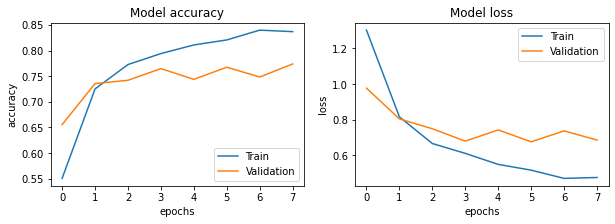

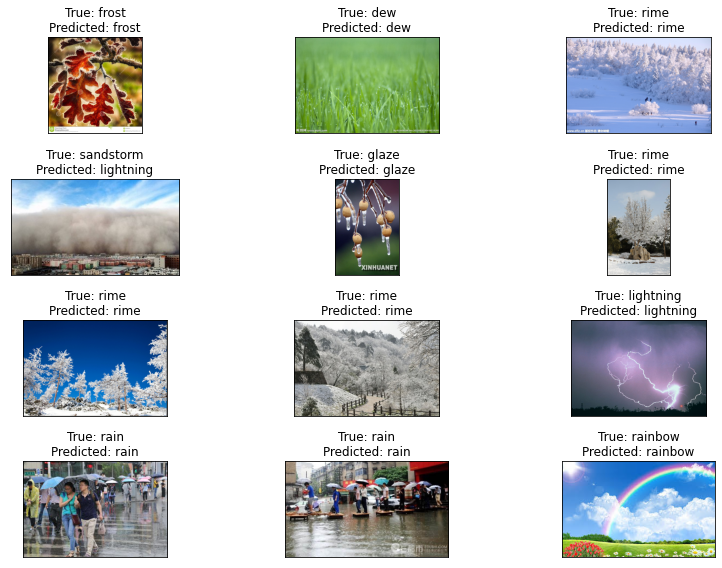

    Test Loss: 0.67648
Test Accuracy: 76.47%


In [11]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

# ResNet

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 51s 1s/step
              precision    recall  f1-score   support

         dew       0.92      0.88      0.90       145
     fogsmog       0.96      0.64      0.77       176
       frost       0.62      0.57      0.60        87
       glaze       0.63      0.73      0.68       116
        hail       0.76      0.96      0.85       113
   lightning       0.94      0.99      0.96        74
        rain       0.94      0.73      0.82       115
     rainbow       0.98      0.92      0.95        53
        rime       0.85      0.86      0.85       230
   sandstorm       0.70      0.99      0.82       143
        snow       0.72      0.65      0.68       121

    accuracy                           0.81      1373
   macro avg       0.82      0.81      0.81      1373
wei

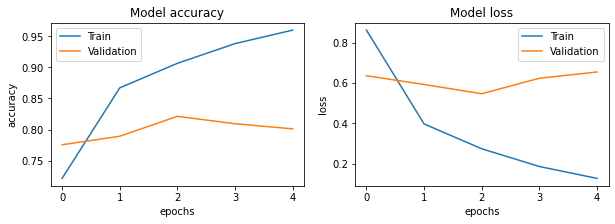

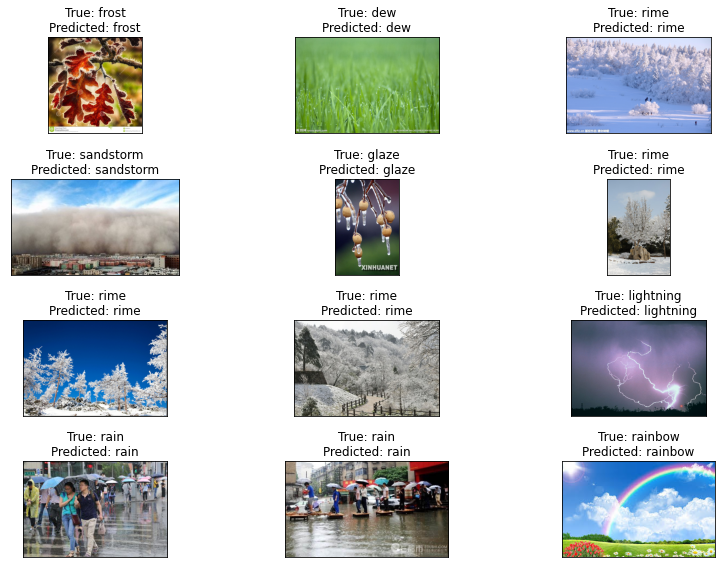

    Test Loss: 0.68640
Test Accuracy: 80.63%


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

# MobileNet

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 20s 421ms/step
              precision    recall  f1-score   support

         dew       0.89      0.91      0.90       145
     fogsmog       0.86      0.90      0.88       176
       frost       0.61      0.64      0.63        87
       glaze       0.66      0.72      0.69       116
        hail       0.84      0.91      0.87       113
   lightning       0.96      0.95      0.95        74
        rain       0.83      0.83      0.83       115
     rainbow       0.98      0.92      0.95        53
        rime       0.80      0.85      0.82       230
   sandstorm       0.87      0.83      0.85       143
        snow       0.80      0.53      0.64       121

    accuracy                           0.82      1373
   macro avg       0.83      0.82      0.82      1373


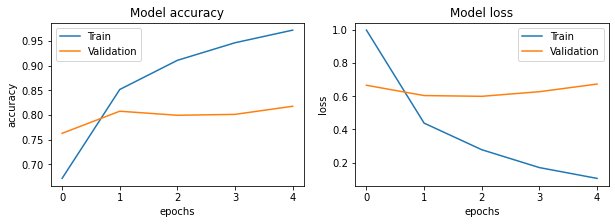

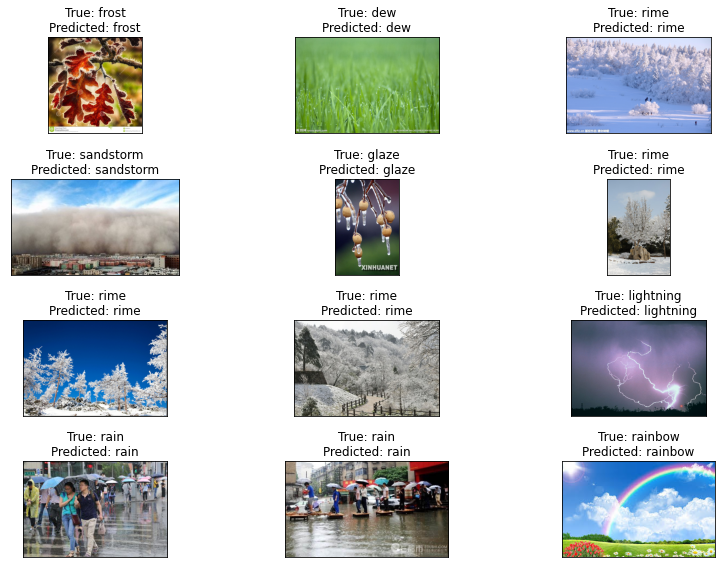

    Test Loss: 0.72586
Test Accuracy: 81.94%


In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

# VGG19

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 146s 3s/step
              precision    recall  f1-score   support

         dew       0.92      0.83      0.88       145
     fogsmog       0.83      0.89      0.85       176
       frost       0.59      0.62      0.61        87
       glaze       0.61      0.56      0.58       116
        hail       0.83      0.84      0.84       113
   lightning       0.92      0.95      0.93        74
        rain       0.81      0.75      0.78       115
     rainbow       0.94      0.85      0.89        53
        rime       0.77      0.84      0.81       230
   sandstorm       0.87      0.84      0.85       143
        snow       0.67      0.68      0.67       121

    accuracy                           0.79      1373
   macro avg       0.80      0.79      0.79      1373
we

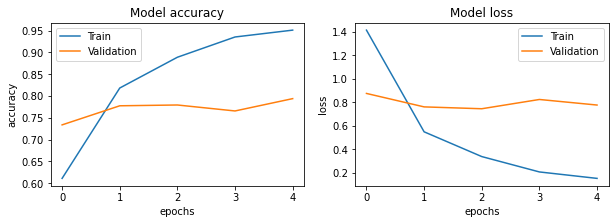

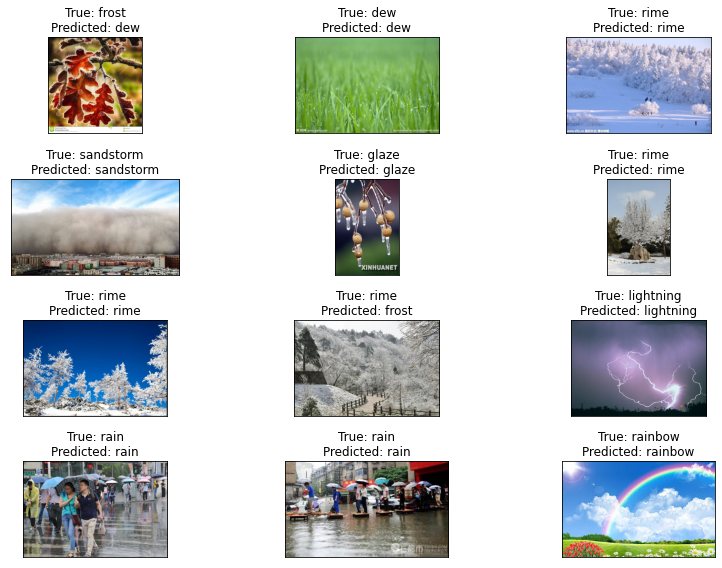

    Test Loss: 0.78651
Test Accuracy: 79.24%


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
VGG19_pre=preprocess_input
train_gen_VGG19, valid_gen_VGG19, test_gen_VGG19 = gen(VGG19_pre,train_df,test_df)
VGG19_model, callback=func(VGG19)
history = VGG19_model.fit(
    train_gen_VGG19,
    validation_data=valid_gen_VGG19,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_VGG19= plot(history,test_gen_VGG19,train_gen_VGG19, VGG19_model)

result_VGG19 = result_test(test_gen_VGG19,VGG19_model)

# Xception

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 58s 1s/step
              precision    recall  f1-score   support

         dew       0.89      0.86      0.87       145
     fogsmog       0.86      0.74      0.79       176
       frost       0.67      0.48      0.56        87
       glaze       0.53      0.74      0.62       116
        hail       0.81      0.83      0.82       113
   lightning       0.91      0.92      0.91        74
        rain       0.80      0.73      0.76       115
     rainbow       0.91      0.81      0.86        53
        rime       0.73      0.85      0.78       230
   sandstorm       0.77      0.89      0.82       143
        snow       0.72      0.46      0.56       121

    accuracy                           0.76      1373
   macro avg       0.78      0.76      0.76      1373
wei

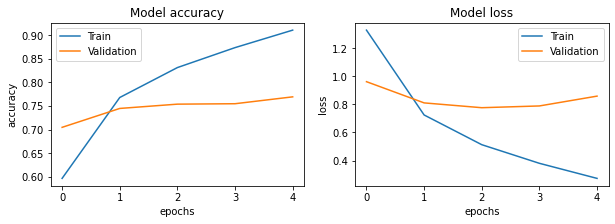

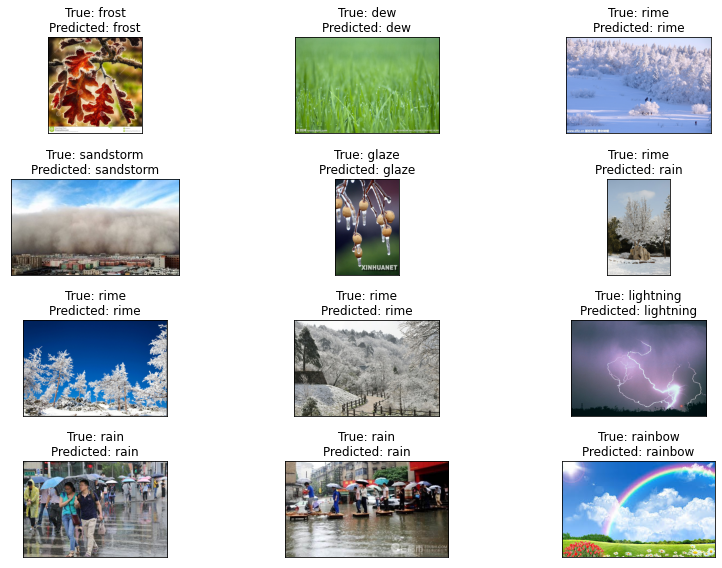

    Test Loss: 0.87771
Test Accuracy: 76.40%


In [15]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

# InceptionResNetV2

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 48s 907ms/step
              precision    recall  f1-score   support

         dew       0.88      0.70      0.78       145
     fogsmog       0.77      0.80      0.78       176
       frost       0.64      0.53      0.58        87
       glaze       0.59      0.63      0.61       116
        hail       0.68      0.81      0.74       113
   lightning       0.93      0.88      0.90        74
        rain       0.81      0.63      0.71       115
     rainbow       0.98      0.89      0.93        53
        rime       0.83      0.65      0.73       230
   sandstorm       0.83      0.80      0.82       143
        snow       0.38      0.69      0.49       121

    accuracy                           0.72      1373
   macro avg       0.76      0.73      0.73      1373


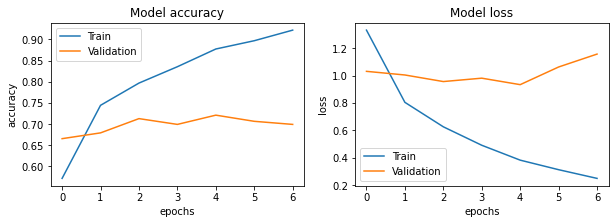

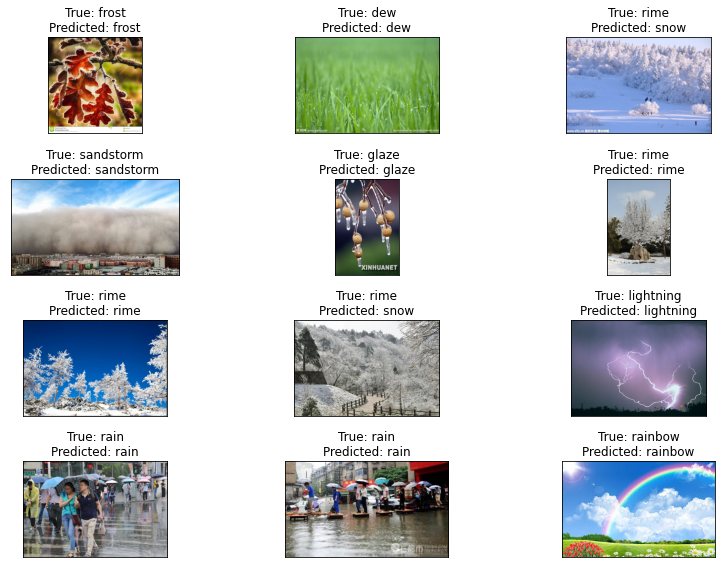

    Test Loss: 1.16593
Test Accuracy: 71.81%


In [16]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
IRNV2_pre=preprocess_input
train_gen_IRNV2, valid_gen_IRNV2, test_gen_IRNV2 = gen(IRNV2_pre,train_df,test_df)
IRNV2_model, callback=func(InceptionResNetV2)
history = IRNV2_model.fit(
    train_gen_IRNV2,
    validation_data=valid_gen_IRNV2,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_IRNV2 =plot(history,test_gen_IRNV2,train_gen_IRNV2, IRNV2_model)
result_IRNV2 = result_tresult_IRNV2 = result_test(test_gen_IRNV2,IRNV2_model)

# VGG16

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 119s 3s/step
              precision    recall  f1-score   support

         dew       0.84      0.88      0.86       145
     fogsmog       0.79      0.89      0.84       176
       frost       0.59      0.54      0.57        87
       glaze       0.62      0.57      0.59       116
        hail       0.88      0.87      0.88       113
   lightning       0.92      0.95      0.93        74
        rain       0.84      0.80      0.82       115
     rainbow       0.98      0.79      0.88        53
        rime       0.86      0.78      0.82       230
   sandstorm       0.91      0.82      0.86       143
        snow       0.57      0.74      0.64       121

    accuracy                           0.79      1373
   macro avg       0.80      0.78      0.79      1373
we

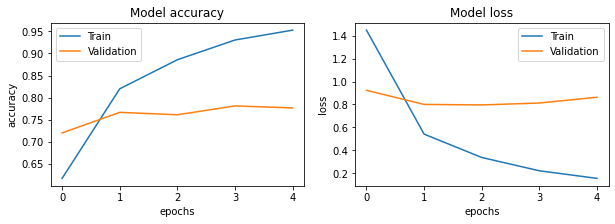

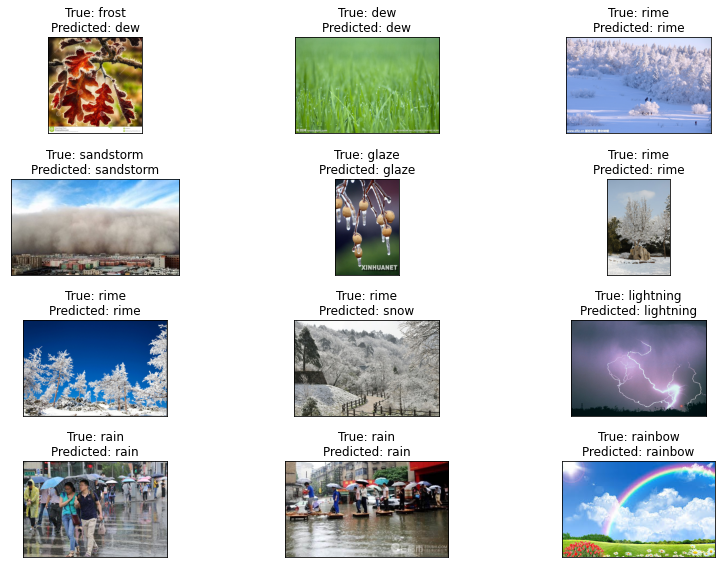

    Test Loss: 0.81799
Test Accuracy: 79.10%


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

# ResNet101

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 91s 2s/step
              precision    recall  f1-score   support

         dew       0.85      0.96      0.90       145
     fogsmog       0.93      0.90      0.92       176
       frost       0.78      0.61      0.68        87
       glaze       0.62      0.59      0.61       116
        hail       0.96      0.82      0.89       113
   lightning       0.93      1.00      0.96        74
        rain       0.90      0.79      0.84       115
     rainbow       0.96      0.92      0.94        53
        rime       0.82      0.83      0.83       230
   sandstorm       0.88      0.94      0.91       143
        snow       0.65      0.77      0.70       121

    accuracy                           0.83      1373
   macro avg       0.84      0.83      0.83      1373
wei

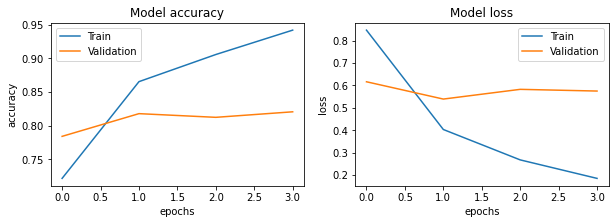

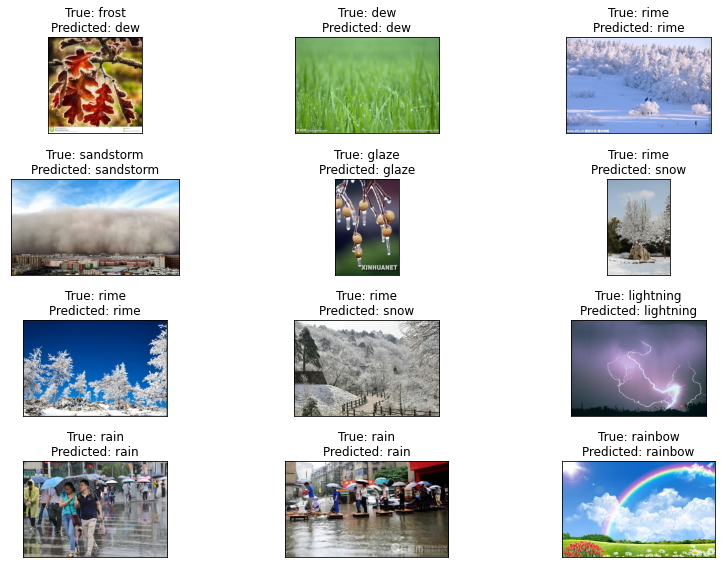

    Test Loss: 0.56006
Test Accuracy: 83.39%


In [18]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)

# DenseNet201

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 111s 2s/step
              precision    recall  f1-score   support

         dew       0.85      0.97      0.91       145
     fogsmog       0.77      0.93      0.84       176
       frost       0.71      0.76      0.73        87
       glaze       0.70      0.70      0.70       116
        hail       0.88      0.88      0.88       113
   lightning       0.95      0.97      0.96        74
        rain       0.86      0.83      0.84       115
     rainbow       0.94      0.89      0.91        53
        rime       0.84      0.82      0.83       230
   sandstorm       0.96      0.73      0.83       143
        snow       0.78      0.66      0.71       121

    accuracy                           0.83      1373
   macro avg       0.84      0.83      0.83      1373
we

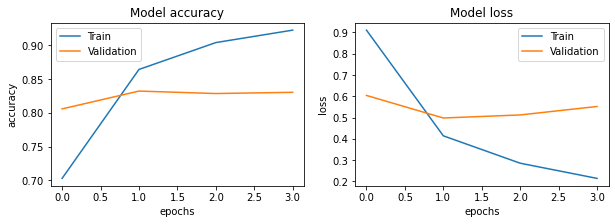

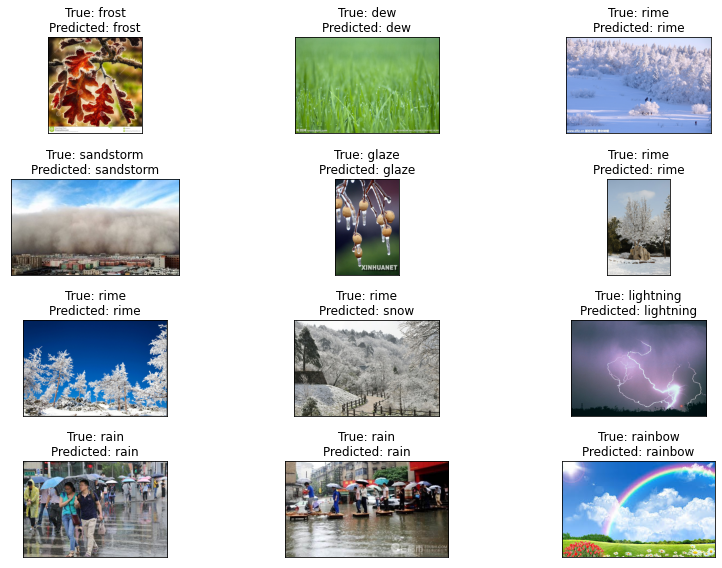

    Test Loss: 0.54366
Test Accuracy: 82.96%


In [22]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

# DenseNet169

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
43/43 [==============================] - 75s 2s/step
              precision    recall  f1-score   support

         dew       0.96      0.90      0.93       145
     fogsmog       0.85      0.89      0.87       176
       frost       0.78      0.44      0.56        87
       glaze       0.68      0.63      0.65       116
        hail       0.88      0.94      0.91       113
   lightning       0.89      0.99      0.94        74
        rain       0.86      0.83      0.84       115
     rainbow       0.94      0.96      0.95        53
        rime       0.77      0.90      0.83       230
   sandstorm       0.90      0.84      0.87       143
        snow       0.69      0.73      0.71       121

    accuracy                           0.83      1373
   macro avg       0.84      0.82      0.82      1373
wei

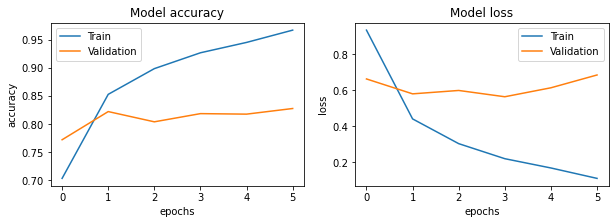

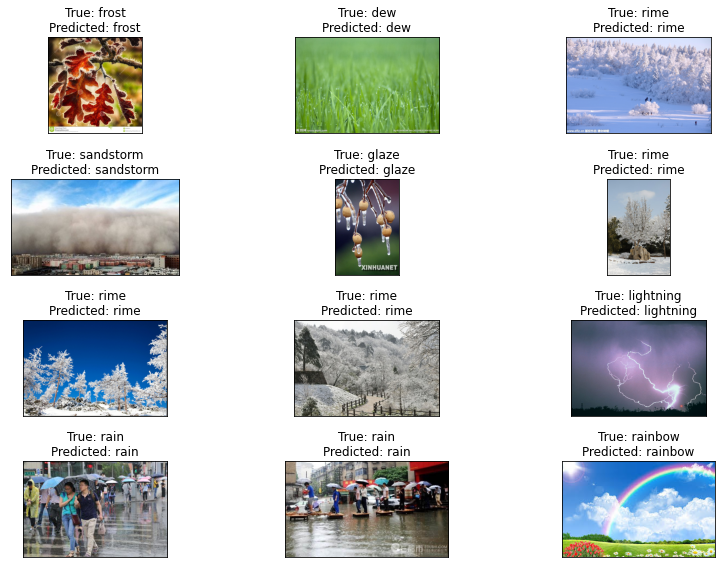

    Test Loss: 0.60020
Test Accuracy: 82.96%


In [24]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet169_pre=preprocess_input
train_gen_DenseNet169, valid_gen_DenseNet169, test_gen_DenseNet169 = gen(DenseNet169_pre,train_df,test_df)
model_DenseNet169, callback=func(DenseNet169)
history = model_DenseNet169.fit(
    train_gen_DenseNet169,
    validation_data=valid_gen_DenseNet169,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet169,train_gen_DenseNet169, model_DenseNet169)
result_DenseNet169 = result_test(test_gen_DenseNet169,model_DenseNet169)

In [26]:
output = pd.DataFrame({'Model':['EfficientNetB7','ResNet50','MobileNet','VGG19','Xception','InceptionResNetV2',
                               'VGG16','ResNet101','DenseNet201','DenseNet169'],
                      'Accuracy':[result_ENet[1], result_ResNet[1], result_MobileNet[1], result_VGG19[1],
                                  result_Xception[1],result_IRNV2[1],result_VGG16[1],result_ResNet101[1],
                                 result_DenseNet201[1],result_DenseNet169[1]]})

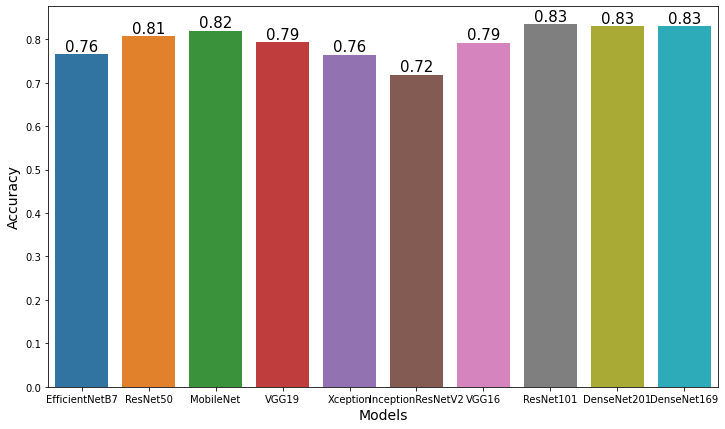

In [27]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()